In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
import glob
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/uOttawa/AI_for_CyberSecurity/InsiderThreatDetection'
answers_path = os.path.join(root_path,'answers')
fine_dataset_path = os.path.join(root_path,'sampled dataset')
coarse_features_path = '/content/drive/MyDrive/uOttawa/AI_for_CyberSecurity/InsiderThreatDetection/CS Processed Features/merged_features.csv'

# Load LDAP, answers, and get malicious users

In [ ]:
DATASET_VER = 5.2
insiders_df = pd.read_csv(os.path.join(answers_path,"insiders.csv"))
insiders_df = insiders_df[(insiders_df['dataset'] == DATASET_VER)]
insiders_df['start'] = pd.to_datetime(insiders_df['start'])
insiders_df = insiders_df.sort_values(by='start', ascending=True)
insiders_df.head()

,dataset,scenario,details,user,start,end
177,5.2,4,r5.2-4-OHS0036.csv,OHS0036,2010-04-16 12:32:57,07/09/2010 10:32:40
148,5.2,3,r5.2-3-MPF0690.csv,MPF0690,2010-06-17 10:00:38,06/18/2010 20:22:06
111,5.2,2,r5.2-2-VCF1602.csv,VCF1602,2010-06-23 15:32:14,08/11/2010 18:01:01
128,5.2,2,r5.2-2-CKP0630.csv,CKP0630,2010-06-28 08:13:30,08/13/2010 12:59:03
115,5.2,2,r5.2-2-ZIE0741.csv,ZIE0741,2010-06-29 13:16:09,08/27/2010 18:13:31


In [ ]:
# get user functional dictionary
all_files = glob.glob(os.path.join(fine_dataset_path,"LDAP/*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
LDAP_df = pd.concat(li, axis=0, ignore_index=True).drop_duplicates()

print(f'length of LDAP : {len(LDAP_df)}')
LDAP_df.head(10)

length of LDAP : 3581


,employee_name,user_id,email,role,projects,business_unit,functional_unit,department,team,supervisor
0,Maisie Maggy Kline,MMK1532,Maisie.Maggy.Kline@dtaa.com,Technician,NaN,2 - Executive,5 - SalesAndMarketing,3 - FieldService,3 - RegionalFieldService,Yvette Naomi Cortez
1,Nicole Tanya Burt,NTB0710,Nicole.Tanya.Burt@dtaa.com,SoftwareQualityEngineer,Project 2,2 - Executive,2 - ResearchAndEngineering,3 - SoftwareManagement,1 - SQA,Brennan Thaddeus Dominguez
2,Madeline Tatum Donaldson,MTD0971,Madeline.Tatum.Donaldson@dtaa.com,ElectricalEngineer,NaN,1 - Executive,2 - ResearchAndEngineering,3 - SoftwareManagement,6 - EmbeddedSoftware,Todd Rajah Peterson
3,Nicholas Hamish Browning,NHB1529,Nicholas.Hamish.Browning@dtaa.com,Technician,NaN,2 - Executive,5 - SalesAndMarketing,3 - FieldService,3 - RegionalFieldService,Yvette Naomi Cortez
4,Hoyt Berk Wiley,HBW0057,Hoyt.Berk.Wiley@dtaa.com,ProjectManager,NaN,1 - Executive,2 - ResearchAndEngineering,1 - ProjectManagement,NaN,Rina Adena Horn
5,Patience Lesley Mccoy,PLM1716,Patience.Lesley.Mccoy@dtaa.com,Salesman,NaN,2 - Executive,5 - SalesAndMarketing,2 - Sales,4 - RegionalSales,Ethan Branden Garrett
6,Ulric Kirk Guthrie,UKG0386,Ulric.Kirk.Guthrie@dtaa.com,ProductionLineWorker,NaN,2 - Executive,3 - Manufacturing,3 - Assembly,1 - AssemblyDept,Prescott Jasper Collins
7,Guinevere Lisandra Chang,GLC1055,Guinevere.Lisandra.Chang@dtaa.com,ProductionLineWorker,NaN,1 - Executive,3 - Manufacturing,3 - Assembly,4 - AssemblyDept,Evangeline Yoko Malone
8,Ulric Ciaran Dunlap,UCD0608,Ulric.Ciaran.Dunlap@dtaa.com,StockroomClerk,NaN,1 - Executive,3 - Manufacturing,3 - Assembly,1 - Stockroom,Sydney Genevieve Nichols
9,Coby Baxter Nguyen,CBN1983,Coby.Baxter.Nguyen@dtaa.com,LabManager,NaN,1 - Executive,2 - ResearchAndEngineering,2 - Research,6 - Lab,Dominique Karly Charles


In [ ]:
def get_user_from_path(path):
    user = path.split('/')[-1].split('.csv')[0].split('-')[-1]
    return user

def read_answer_file(path):
    df = pd.read_csv(path, header=None, usecols=[0,1,2,3,4]).rename(columns={0: 'action',
                                                                            1: 'ID',
                                                                            2: 'date',
                                                                            3: 'user',
                                                                            4: 'pc'})
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.date
    return df

def read_malicious_events(answers_dir, dataset_ver=5.2):
    mal_event_paths = glob.glob(os.path.join(answers_dir, f'r{dataset_ver}-*/*'))
    mal_users = [get_user_from_path(p) for p in mal_event_paths]
    mal_user_events = {user: read_answer_file(path)
                       for (user, path) in zip(mal_users, mal_event_paths)}
    return mal_user_events

In [ ]:
mal_users_events = read_malicious_events(answers_path)

In [ ]:
def is_malicious_day(x , mal_users_events):
    day = x.day
    user = x.user

    if(user not in mal_users_events):
        return 0
    user_df = mal_users_events[user]
    mal_events_count = user_df[(user_df['day'] == day)].shape[0]
    return int(mal_events_count > 0)

def is_malicious_user(user, X, clf, all_features):
  idxs = all_features[all_features["user"] == user].index.values
  user_preds = clf.predict(X.loc[idxs])
  return int(user_preds.any())

# Load fine data

In [ ]:
import glob 

feature_dfs = []
features_path = os.path.join(root_path,'New_features/*.csv')
for path in glob.glob(features_path):
  print(path)
  df = pd.read_csv(path)
  feature_dfs.append(df)

/content/drive/MyDrive/uOttawa/AI_for_CyberSecurity/InsiderThreatDetection/New_features/user_daily_email.csv
/content/drive/MyDrive/uOttawa/AI_for_CyberSecurity/InsiderThreatDetection/New_features/user_daily_http.csv
/content/drive/MyDrive/uOttawa/AI_for_CyberSecurity/InsiderThreatDetection/New_features/user_daily_device.csv
/content/drive/MyDrive/uOttawa/AI_for_CyberSecurity/InsiderThreatDetection/New_features/user_daily_file.csv
/content/drive/MyDrive/uOttawa/AI_for_CyberSecurity/InsiderThreatDetection/New_features/user_daily_logon.csv


In [ ]:
from functools import reduce

fine_features = reduce(lambda left, right: pd.merge(left, right, on=['user', 'day'],
                                               how='outer'), feature_dfs).fillna(0)
fine_features['day'] = pd.to_datetime(fine_features['day'])
fine_features['is_malicious'] = fine_features.apply(is_malicious_day, 
                                                       args=[mal_users_events],
                                                       axis=1)

fine_features

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,day,user,count_Receive_working_hour_personal_pc_0_0,count_Send_working_hour_personal_pc_0_0,count_Receive_working_hour_personal_pc_1_0,count_Send_working_hour_personal_pc_1_0,count_Send_working_hour_personal_pc_1_1,count_Receive_after_hours_personal_pc_0_0,count_Receive_after_hours_personal_pc_1_0,count_Send_after_hours_personal_pc_0_0,...,file_length,file_depth_y,count_Logon_working_hour_other_pc,count_Logon_working_hour_personal_pc,count_Logon_after_hours_other_pc,count_Logon_after_hours_personal_pc,count_Logon_after_hours_supervisor_pc,count_Logon_working_hour_supervisor_pc,session_time,is_malicious
0,2010-01-02,ELT1370,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,163.666667,0
1,2010-01-02,ESM1828,5.0,5.0,12.0,7.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,276.500000,0
2,2010-01-02,GVM1337,5.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,277.000000,0
3,2010-01-02,HJB1444,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
4,2010-01-02,ILM1441,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,261.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62525,2011-01-15,JOB0532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,118.000000,0
62526,2011-02-27,JOB0532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49.000000,0
62527,2011-03-19,CTM1817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,194.000000,0
62528,2011-03-19,GDC0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,57.000000,0


# Train/test splits by user

In [ ]:
import random

def sample_random_users(features, insiders_df, test_size=0.25, random_state=0):
  all_malicious_users = insiders_df['user'].values
  all_users = features["user"].values
  
  random.seed(random_state)

  malicious_users = list(set(all_malicious_users).intersection(all_users))
  benign_users = list(set(all_users).difference(malicious_users))

  test_malicious_users = random.sample(malicious_users, 
                                      int(len(malicious_users)*test_size))
  test_benign_users = random.sample(benign_users, 
                                      int(len(benign_users)*test_size))
  
  train_malicious_users = list(set(malicious_users).difference(test_malicious_users))
  train_benign_users = list(set(benign_users).difference(test_benign_users))

  train_users = train_benign_users + train_malicious_users
  test_users = test_benign_users + test_malicious_users
  return train_users, test_users

In [ ]:
train_users, test_users = sample_random_users(fine_features, insiders_df)
drop_cols = ["day", "user", "is_malicious"]

In [ ]:
user_train_features_fine = fine_features[fine_features['user'].isin(train_users)]
user_test_features_fine = fine_features[fine_features['user'].isin(test_users)]

X_train_user_fine = user_train_features_fine.drop(columns=drop_cols)
y_train_user_fine = user_train_features_fine.iloc[:, -1]

X_test_user_fine = user_test_features_fine.drop(columns=drop_cols)
y_test_user_fine = user_test_features_fine.iloc[:, -1]

print(f"train shape: {X_train_user_fine.shape}")
print(f"test shape: {X_test_user_fine.shape}")

train shape: (46421, 102)
test shape: (16109, 102)


#Top Features

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix,classification_report


rf = RandomForestClassifier(max_features="log2")
rf.fit(X_train_user_fine, y_train_user_fine)

user_fine_preds = rf.predict(X_test_user_fine)

In [ ]:
X_train_user_fine.shape

(46421, 102)

In [ ]:
print(f'accuracy : {accuracy_score(y_test_user_fine, user_fine_preds)}')
print(f'f1_score : {f1_score(y_test_user_fine, user_fine_preds)}')
print(classification_report(y_test_user_fine, user_fine_preds))

accuracy : 0.9931094419268732
f1_score : 0.7527839643652563
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15840
           1       0.94      0.63      0.75       269

    accuracy                           0.99     16109
   macro avg       0.97      0.81      0.87     16109
weighted avg       0.99      0.99      0.99     16109



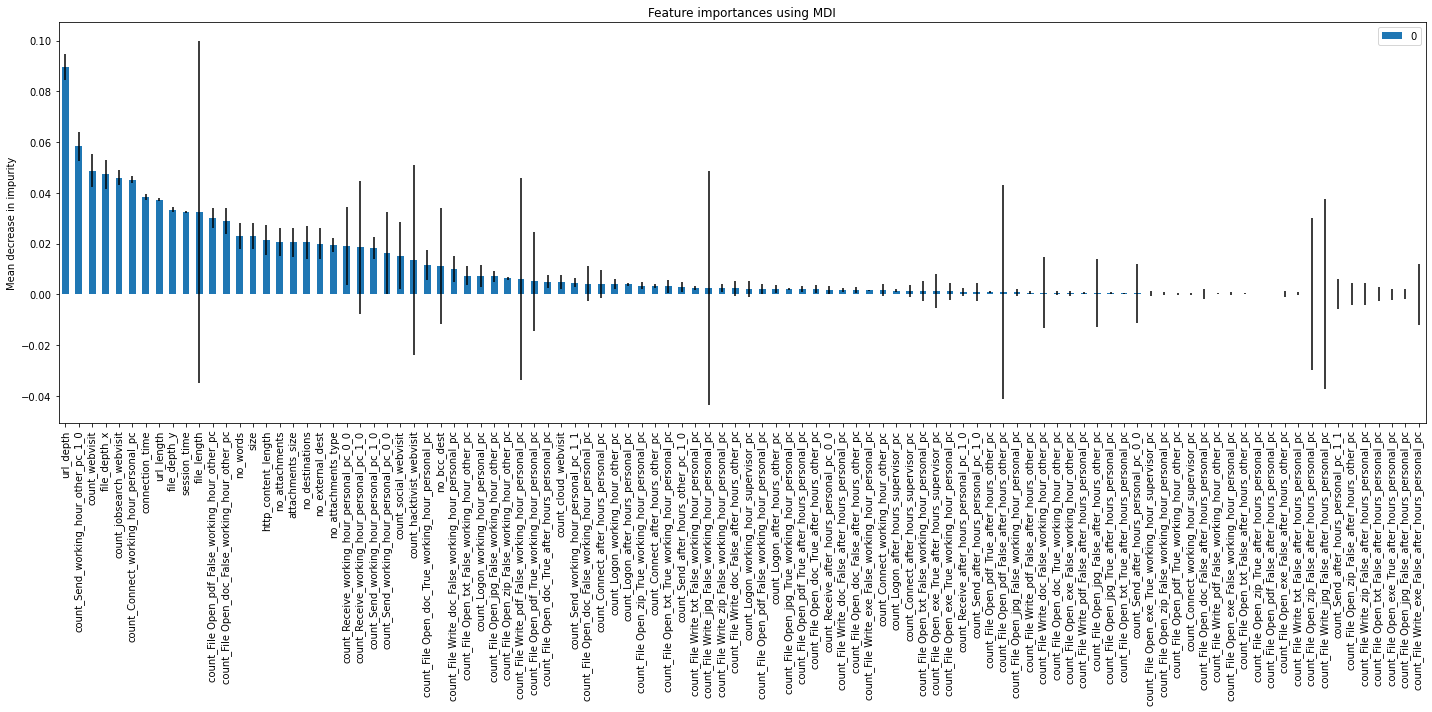

In [ ]:
feature_names = X_train_user_fine.columns
importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(20, 10))
forest_importances.to_frame().sort_values(by=0, ascending=False).plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
best_feature_comb = {}

for i in range(5, 80):
  top_features = forest_importances.to_frame().sort_values(by=0, ascending=False).iloc[:i].index.values

  X_train_top_features = X_train_user_fine[top_features]
  X_test_top_features = X_test_user_fine[top_features]

  rf = RandomForestClassifier(max_features='log2')
  rf.fit(X_train_top_features, y_train_user_fine)

  preds = rf.predict(X_test_top_features)
  f1 = f1_score(y_test_user_fine, preds)
  print(f'f1_score for {i} : {f1}')
  best_feature_comb[i] = f1

f1_score for 5 : 0.6158631415241058
f1_score for 6 : 0.47438752783964366
f1_score for 7 : 0.5490196078431372
f1_score for 8 : 0.47415730337078654
f1_score for 9 : 0.7290969899665551
f1_score for 10 : 0.6817447495961229
f1_score for 11 : 0.7026143790849674
f1_score for 12 : 0.6963696369636964
f1_score for 13 : 0.6942148760330578
f1_score for 14 : 0.7477638640429337
f1_score for 15 : 0.7403314917127072
f1_score for 16 : 0.7349177330895794
f1_score for 17 : 0.7150837988826815
f1_score for 18 : 0.7255278310940501
f1_score for 19 : 0.7262569832402235
f1_score for 20 : 0.7192307692307692
f1_score for 21 : 0.7131782945736436
f1_score for 22 : 0.71484375
f1_score for 23 : 0.6953125
f1_score for 24 : 0.7151515151515152
f1_score for 25 : 0.7250509164969451
f1_score for 26 : 0.7139959432048681
f1_score for 27 : 0.7258064516129032
f1_score for 28 : 0.7280163599182004
f1_score for 29 : 0.7782805429864252
f1_score for 30 : 0.7982261640798227
f1_score for 31 : 0.7770419426048565
f1_score for 32 : 0.7

In [ ]:
max = 0
feature = -1
for k , v in best_feature_comb.items():
  if v > max:
    max = v
    feature = k
print(f'num of features : {feature} , f1-score : {max}')

num of features : 30 , f1-score : 0.7982261640798227


In [ ]:
forest_importances.to_frame().sort_values(by=0, ascending=False).iloc[:30].index.values

array(['url_depth', 'count_Send_working_hour_other_pc_1_0',
       'count_webvisit', 'file_depth_x', 'count_jobsearch_webvisit',
       'count_Connect_working_hour_personal_pc', 'connection_time',
       'url_length', 'file_depth_y', 'session_time', 'file_length',
       'count_File Open_pdf_False_working_hour_other_pc',
       'count_File Open_doc_False_working_hour_other_pc', 'no_words',
       'size', 'http_content_length', 'no_attachments',
       'attachments_size', 'no_destinations', 'no_external_dest',
       'no_attachments_type',
       'count_Receive_working_hour_personal_pc_0_0',
       'count_Receive_working_hour_personal_pc_1_0',
       'count_Send_working_hour_personal_pc_1_0',
       'count_Send_working_hour_personal_pc_0_0', 'count_social_webvisit',
       'count_hacktivist_webvisit',
       'count_File Open_doc_True_working_hour_personal_pc', 'no_bcc_dest',
       'count_File Write_doc_False_working_hour_personal_pc'],
      dtype=object)

#Models

In [ ]:
import pickle
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix,classification_report

In [ ]:
top_features = ['url_depth', 'count_Send_working_hour_other_pc_1_0',
       'count_webvisit', 'file_depth_x', 'count_jobsearch_webvisit',
       'count_Connect_working_hour_personal_pc', 'connection_time',
       'url_length', 'file_depth_y', 'session_time', 'file_length',
       'count_File Open_pdf_False_working_hour_other_pc',
       'count_File Open_doc_False_working_hour_other_pc', 'no_words',
       'size', 'http_content_length', 'no_attachments',
       'attachments_size', 'no_destinations', 'no_external_dest',
       'no_attachments_type',
       'count_Receive_working_hour_personal_pc_0_0',
       'count_Receive_working_hour_personal_pc_1_0',
       'count_Send_working_hour_personal_pc_1_0',
       'count_Send_working_hour_personal_pc_0_0', 'count_social_webvisit',
       'count_hacktivist_webvisit',
       'count_File Open_doc_True_working_hour_personal_pc', 'no_bcc_dest',
       'count_File Write_doc_False_working_hour_personal_pc']

X_train_top_features = X_train_user_fine[top_features]
X_test_top_features = X_test_user_fine[top_features]

## Random Forest

In [ ]:
# parameter tunning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {"max_features": ["sqrt", "log2"], 
              "max_depth":[1,2,3,4,5,6,7,8,9,10, None],
              "class_weight":["balanced", None]}

              
rf_rand = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid,
                             verbose=2, scoring="f1_micro", n_iter=30)

rf_rand.fit(X_train_top_features, y_train_user_fine)

In [ ]:
rf_rand.best_estimator_

RandomForestClassifier(max_features='sqrt')

In [ ]:
# fit best model
rf = rf_rand.best_estimator_
rf.fit(X_train_top_features, y_train_user_fine)

rf_preds = rf.predict(X_test_top_features)

print(f'accuracy : {accuracy_score(y_test_user_fine,rf_preds)}')
print(f'f1_score : {f1_score(y_test_user_fine,rf_preds)}')
print(classification_report(y_test_user_fine , rf_preds))

accuracy : 0.9941647526227575
f1_score : 0.7938596491228069
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15840
           1       0.97      0.67      0.79       269

    accuracy                           0.99     16109
   macro avg       0.98      0.84      0.90     16109
weighted avg       0.99      0.99      0.99     16109



In [ ]:
# save model
filename = 'random_forest.sav'
path = os.path.join(root_path ,'Models/user_fine', filename)
pickle.dump(rf, open(path, 'wb'))

**Based on Days**

Text(0.5, 69.0, 'predicted label')

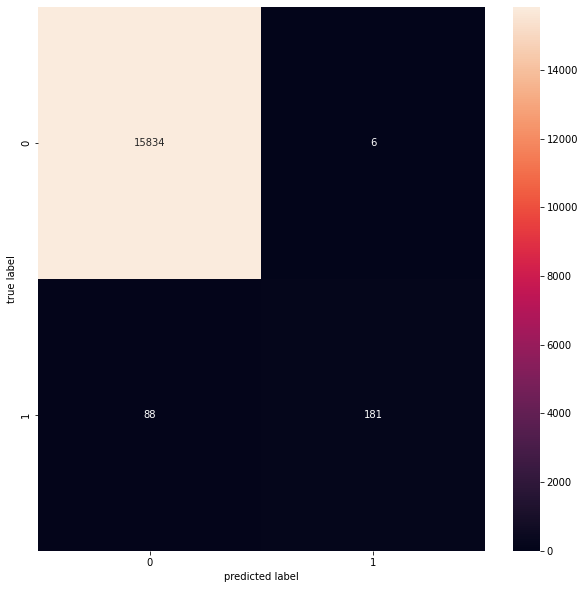

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

conf_matrix = confusion_matrix(y_test_user_fine, rf_preds)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


**Based on Users**

Text(0.5, 69.0, 'predicted label')

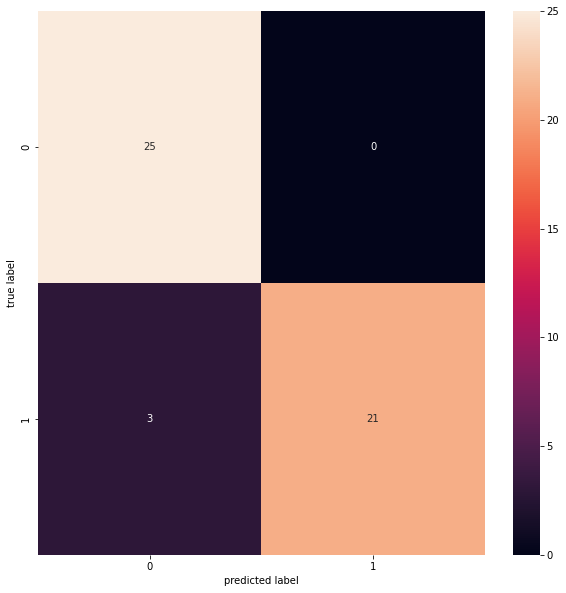

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

test_user_preds = pd.DataFrame()
test_user_preds["user"] = fine_features.loc[X_test_user_fine.index.values].user.unique()
test_user_preds["gt_malicious"] = test_user_preds['user'].apply(lambda x: int(x in mal_users_events))

test_user_preds["pred_malicious"] = test_user_preds['user'].apply(is_malicious_user,
                                                                  args=[X_test_top_features, rf, fine_features])

conf_matrix = confusion_matrix(test_user_preds.gt_malicious.values,
                               test_user_preds.pred_malicious.values)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


##XGBoost

In [ ]:
# parameter tunning
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_grid = {"subsample": np.arange(0.5,1,0.1), 
              "max_depth": np.arange(3,25),
              "n_estimators ":np.arange(50,300)}

              
xgboost_rand = RandomizedSearchCV(XGBClassifier(), param_distributions=param_grid,
                             verbose=2, scoring="f1_micro", n_iter=30)
xgboost_rand.fit(X_train_top_features, y_train_user_fine)

In [ ]:
xgboost_rand.best_estimator_

XGBClassifier(max_depth=7, n_estimators =112, subsample=0.8999999999999999)

In [ ]:
# fit best model
xgboost = xgboost_rand.best_estimator_
xgboost.fit(X_train_top_features, y_train_user_fine)

xg_preds = xgboost.predict(X_test_top_features)

print(f'accuracy : {accuracy_score(y_test_user_fine,xg_preds)}')
print(f'f1_score : {f1_score(y_test_user_fine,xg_preds)}')
print(classification_report(y_test_user_fine , xg_preds))

accuracy : 0.995716680116705
f1_score : 0.8577319587628865
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15840
           1       0.96      0.77      0.86       269

    accuracy                           1.00     16109
   macro avg       0.98      0.89      0.93     16109
weighted avg       1.00      1.00      1.00     16109



In [ ]:
# save model
filename = 'xgboost.sav'
path = os.path.join(root_path ,'Models/user_fine', filename)
pickle.dump(xgboost, open(path, 'wb'))

**Based on Days**

Text(0.5, 69.0, 'predicted label')

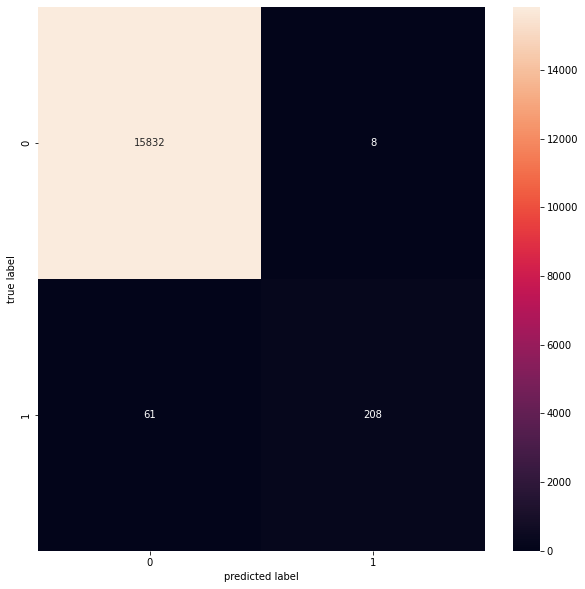

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

conf_matrix = confusion_matrix(y_test_user_fine, xg_preds)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


**Based on Users**

Text(0.5, 69.0, 'predicted label')

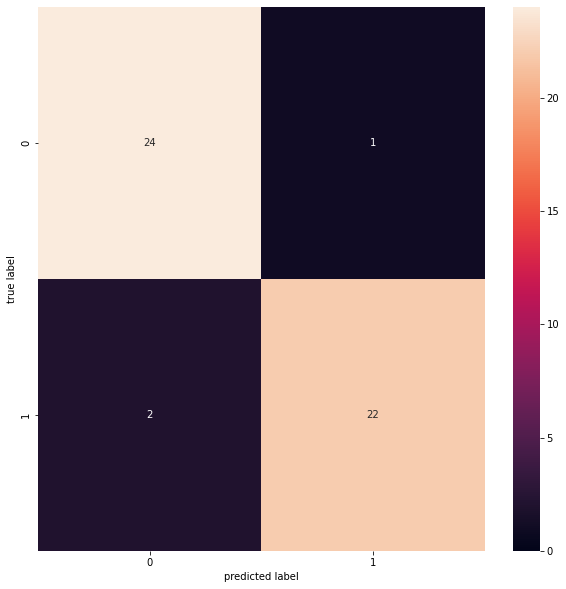

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

test_user_preds = pd.DataFrame()
test_user_preds["user"] = fine_features.loc[X_test_user_fine.index.values].user.unique()
test_user_preds["gt_malicious"] = test_user_preds['user'].apply(lambda x: int(x in mal_users_events))

test_user_preds["pred_malicious"] = test_user_preds['user'].apply(is_malicious_user,
                                                                  args=[X_test_top_features, xgboost, fine_features])

conf_matrix = confusion_matrix(test_user_preds.gt_malicious.values,
                               test_user_preds.pred_malicious.values)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


##CatBoost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

catBoost = CatBoostClassifier()

catBoost.fit(X_train_top_features, y_train_user_fine)

In [ ]:
catBoost_preds = catBoost.predict(X_test_top_features)

print(f'accuracy : {accuracy_score(y_test_user_fine,catBoost_preds)}')
print(f'f1_score : {f1_score(y_test_user_fine,catBoost_preds)}')
print(classification_report(y_test_user_fine , catBoost_preds))

accuracy : 0.9951579862188838
f1_score : 0.8458498023715414
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15840
           1       0.90      0.80      0.85       269

    accuracy                           1.00     16109
   macro avg       0.95      0.90      0.92     16109
weighted avg       0.99      1.00      1.00     16109



In [ ]:
# save model
filename = 'catboost.sav'
path = os.path.join(root_path ,'Models/user_fine', filename)
pickle.dump(catBoost, open(path, 'wb'))

**Based on Days**

Text(0.5, 69.0, 'predicted label')

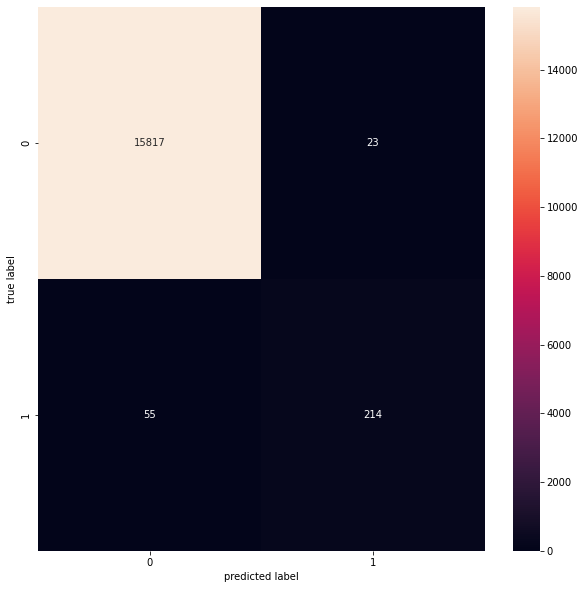

In [ ]:

conf_matrix = confusion_matrix(y_test_user_fine, catBoost_preds)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


**Based on Users**

Text(0.5, 69.0, 'predicted label')

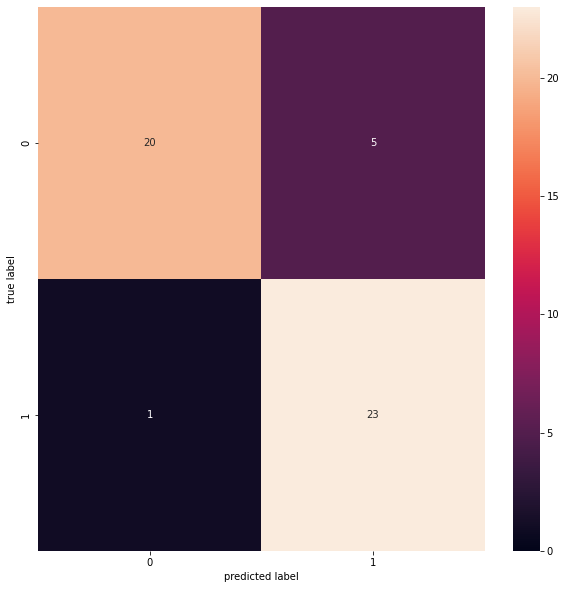

In [ ]:

test_user_preds = pd.DataFrame()
test_user_preds["user"] = fine_features.loc[X_test_user_fine.index.values].user.unique()
test_user_preds["gt_malicious"] = test_user_preds['user'].apply(lambda x: int(x in mal_users_events))

test_user_preds["pred_malicious"] = test_user_preds['user'].apply(is_malicious_user,
                                                                  args=[X_test_top_features, catBoost, fine_features])

conf_matrix = confusion_matrix(test_user_preds.gt_malicious.values,
                               test_user_preds.pred_malicious.values)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")
